In [3]:
from random import choice

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
# If you do nothave scikit-learn installed, uncomment the following line
# !conda install -y -c conda-forge scikit-learn

If you have issues with VSCode notebook cell outputs being truncated:

- Go to Settings (via menubar or cmd-, on Mac)
- Search for cell output settings: try @tag:notebookOutputLayout
- Adjust settings, e.g. scrolling, number of lines to display

# Workshop - ML predictions of aqueous solubility

## Introduction

In this workshop, you will get some hands on practice of applying some of the major machine learning (ML) models to a chemical dataset.

### The data

AqSolDB ([Sorkun et al.](https://doi.org/10.1038/s41597-019-0151-1)) is a curated dataset of experimentally-determined aqueous solubility values, with calculated descriptors for the molecules.

The paper gives details on how the data was acquired and processed, and its availability on a number of platforms including [github](https://github.com/mcsorkun/AqSolDB)


### The task

Prepare the data for training and evaulating a set of machine learning models to predict the solubilty of the compounds based on the features supplied (and others if you would like to calculate additional descriptors as features).

You will use scikit-learn to train and evaluate the following models:

**Supervised learning**

- Linear regression
- Logistic regression
- k-Nearest neighbors



**Unsupervised learning** 
:::{note}
There is a separate notebook for this, if we get on to it. It will not be assessed.
:::


- k-Means clustering
- PCA for dimensionality reduction

#### Steps

1. Load the data
2. Perform some EDA to gain initial understanding of the distribution of features and relationships between features, and with the target.

For each model (may require additional stages depending on the model)

3. Prepare the data 
4. Train the model
5. Make predictions
6. Evaluate performance

7. Analyse the performance of the models. Draw conclusions about the chemical problem, e.g. from the feature importances.

## Load the data and perform exploratory analysis

You can perform some initial exploratory analysis of the dataset using some of the methods you saw last week.

In addition to looking for distribution and patterns in the data, look at what the columns actually contain. Some will include metadata about the source of the observation and its processing, which will not be relevant to the target variable.

In [39]:
# TODO: 
# - Check the data and load into a DataFrame
# - Check the data types
solubility_data = 'curated-solubility-dataset.csv'
df = pd.read_csv(solubility_data)
# - Check for missing values
# - Check summary statistics
df.describe()
# - Identify redundant columns
df_clean = df.drop(columns=["ID","Name","InChI","InChIKey","SMILES","Group"])
df_clean.head()





,Solubility,SD,Ocurrences,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,-3.616127,0.0,1,392.510,3.9581,102.4454,23.0,0.0,0.0,2.0,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,-3.254767,0.0,1,169.183,2.4055,51.9012,13.0,1.0,1.0,2.0,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,-2.177078,0.0,1,140.569,2.1525,36.8395,9.0,1.0,0.0,2.0,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,-3.924409,0.0,1,756.226,8.1161,200.7106,53.0,6.0,2.0,7.0,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,-4.662065,0.0,1,422.525,2.4854,119.0760,31.0,6.0,0.0,6.0,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


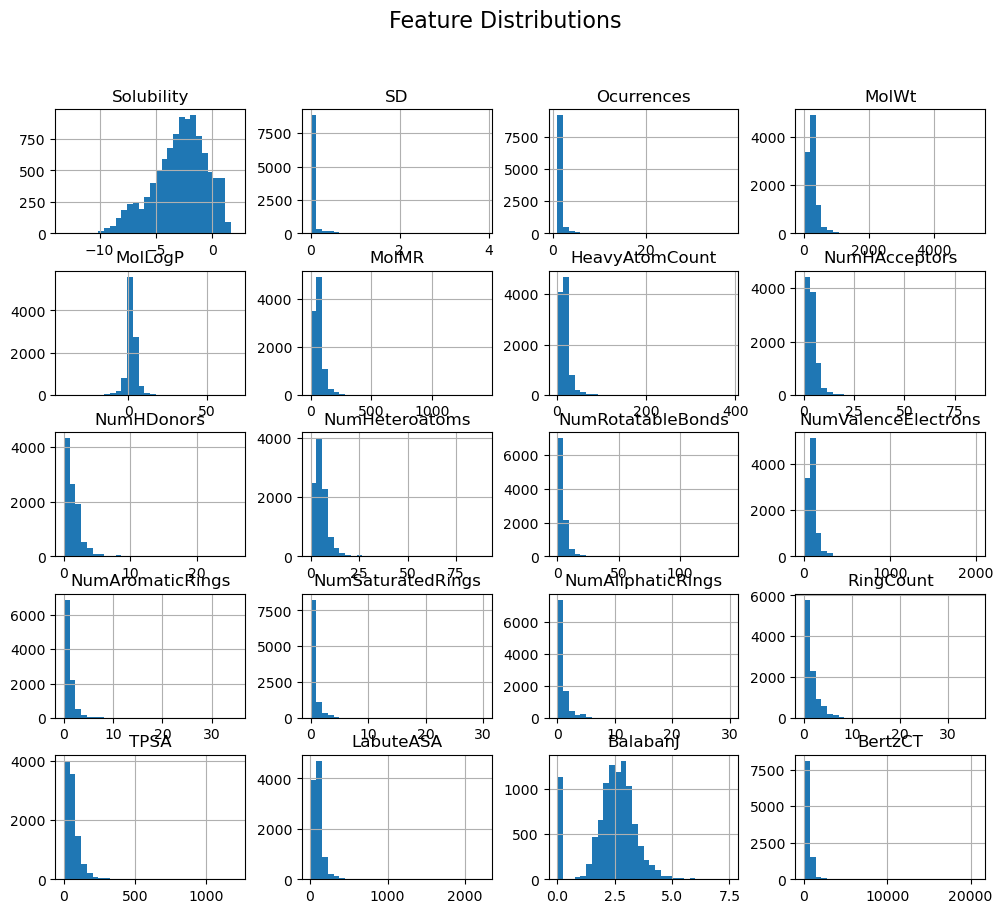

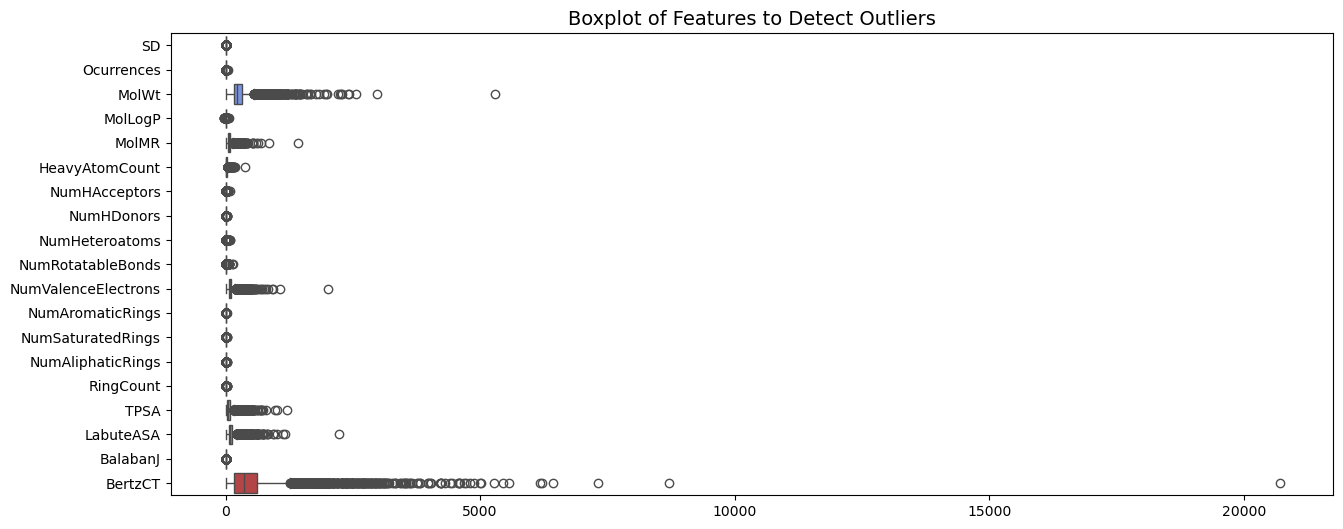

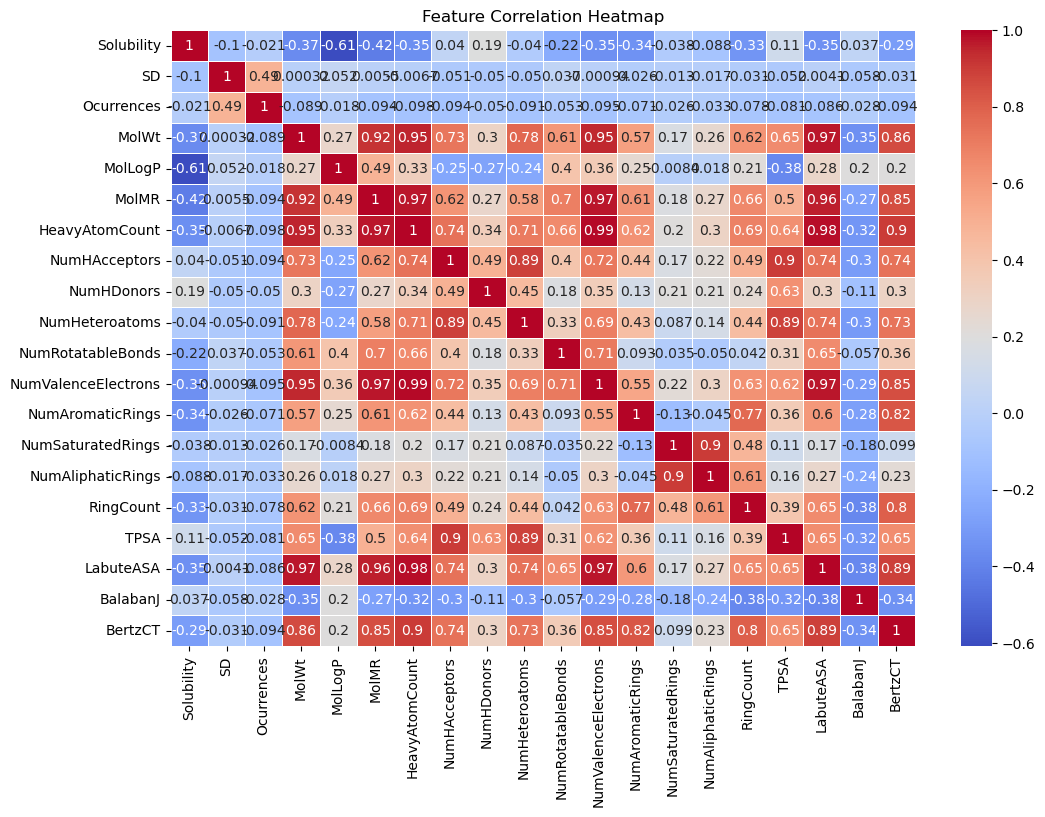

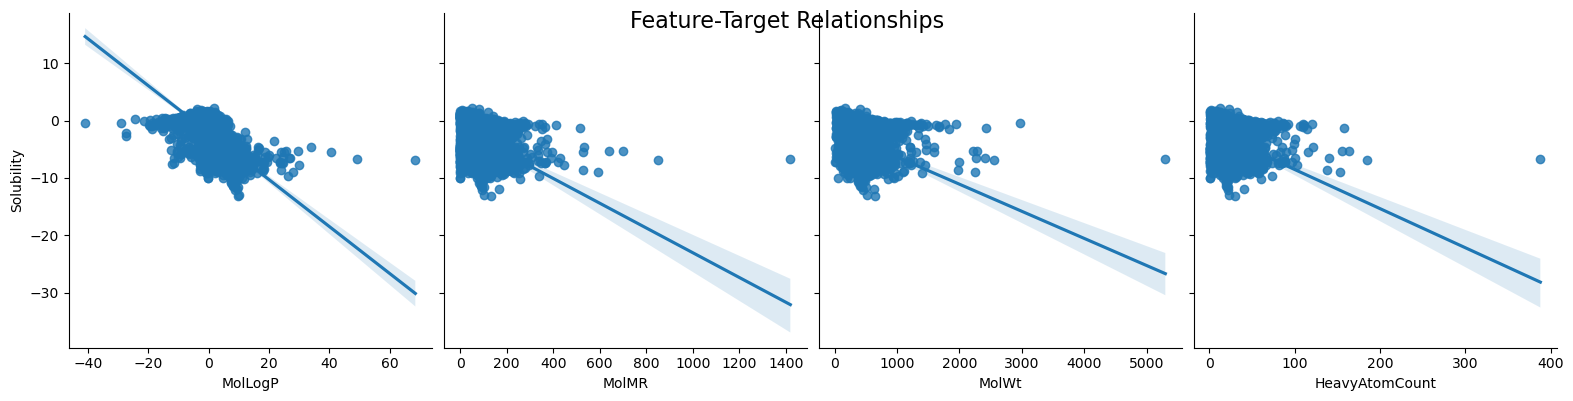

In [40]:
# TODO:
# - Visualise the data to look for distributions of features, check for outliers
numeric_columns = df_clean.select_dtypes(include=["float64", "int64"]).columns
df_clean[numeric_columns].hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(data=df_clean.drop(columns=['Solubility']), orient="h", palette="coolwarm")
plt.title("Boxplot of Features to Detect Outliers", fontsize=14)
plt.show()

# - Visualise the data to look for correlations
correlation_matrix = df_clean.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# - Visualise the data to look for relationships between features and target
top_features = correlation_matrix['Solubility'].abs().sort_values(ascending=False).index[1:5]

# Pairplot for top features
sns.pairplot(df_clean, x_vars=top_features, y_vars=['Solubility'], kind="reg", height=4)
plt.suptitle("Feature-Target Relationships", fontsize=16)
plt.show()

### Questions:

- Explain your approach to EDA for the dataset. What questions can this process answer and suggest how it can aid the subsequent analysis and modelling.

Remove the redundant features columns(ID, Name, InChI, and SMILES), analyze the data distribution, explore the correlation of data using heatmap, and visual the relationship between soluability and the most four most related feartures.
Questions can be answers by EDA appoach: What the most related features to solubility? How is the relationship between these data and solubility? What are the features related to solubility(remove the redundant features)?
For the following analysis, EDA can aid data processing(remove the outliers),model selection(accorrding to the correlations), feature engineering(choosing the most related features).

- What are the most significant correlations in this dataset? Discuss any strong relationships between the features and the target variable that are apparent.

MolLogP is the strongest predictor of solubility (-0.61), indicating that higher lipophilicity leads to lower solubility.
Molecular weight (MolWt) also plays a significant role, with larger molecules tending to have lower solubility.

- If you were selecting features from the data, are there any that you would remove? Explain why/why not.

The features except from MolLogP,MolMR,MolWt,HeavyAtomCount. Because these features are not strongly related to solubility.

#### Things to consider

- Note the distributions of values of features (e.g. the measures of centre, the magnitude and shape of the distribution and the range of the values).


## 1. Linear regression

The first model we will apply is a [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Linear regression models the relationship between input features and a continuous target variable using a linear function.

The function looks like:  

$$
y = w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n + \epsilon
$$

Where:  
- $ y $ = **Predicted output** (target variable)  
- $ x_1, x_2, \dots, x_n $ = **Input features** (independent variables)  
- $ w_0 $ = **Intercept** (bias term)  
- $ w_1, w_2, \dots, w_n $ = **Coefficients** (weights)  
- $ \epsilon $ = **Error term** (accounts for noise in data)  

The goal is to find weights $w_{i}$ that minimize the error, typically using Ordinary Least Squares (OLS).

It finds a best-fit line by minimising the difference between predictions and actual values, typically using least squares. 

It is widely used for trend analysis, forecasting, and understanding feature impact on outcomes.

### Prepare data

To prepare the data, create a new dataframe containing only the numerical features of the AqSolDB dataset.

#### Separate features and target

You can now separate your data into the features (the predictor variables) and target (the variable you want to predict).

In [41]:
# TODO:
# - Read the target column into a separate variable
# - Read the feature columns into a different variable - remember to drop the target column
y = df_clean["Solubility"]
X = df_clean.drop(columns=["Solubility"])



#### Create the training and test sets

Run [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create separate training and test sets, with 20% of the samples in the test set.

In [71]:
# TODO Split the data into training (80%) and testing (20%) sets
# and check the size of the resulting datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y = df_clean['Solubility']
X = df_clean.drop(columns=['Solubility'])
print( X_train.shape)
print( X_test.shape)
print( y_train.shape)
print( y_test.shape)

(7985, 19)
(1997, 19)
(7985,)
(1997,)


### Training the model

It is time to train the first ML model.

You will need to create a new LinearRegression model and train it using its `fit` method on the training data's features.

In [72]:
# TODO: Create a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# TODO: Fit the model to the training data
model.fit(X_train, y_train)


LinearRegression()

### Test the model's performance on unseen data

You can now get the model to predict the solubilities for the subset of data you withheld for the test set.

In [73]:
# TODO: Predict the solubility of the test set
# Predict the solubility of the test set
y_pred = model.predict(X_test)



### Evaluating the model's performance

We can visualise how closely the predicted solubility values for both the training and/or test set match the real values.

:::{hint}
You will need to also generate predictions for the test set if you want to visualise
:::

There are a variety of metrics that can be used to quantify the model's performance. 

One commonly used metric for regression tasks is $r^2$ which expresses how well the model fits the data. It ranges from 0 to 1, with 1 indicating a perfect fit.

In [81]:
# TODO: Calculate r^2 value is a measure of how well the model fits the data. It ranges from 0 to 1, 
# with 1 indicating a perfect fit.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


R² Score: 0.5002


### Questions

- What other metrics might be useful for evaluating the model's performance? Choose one other metric and calculate it for the model's perform on the test data. Briefly explain the form and meaning of the metric.

Mean Absolute Error (MAE) can also be used in evaluating the model's performance. 

MAE measures the average absolute difference between the actual (y_test) and predicted (y_pred) solubility values.Lower MAE is better → it means the predictions are closer to actual values.

As the below calculated result MAE=1.2059

- Comment on the performance of the model on the training vs. the test data. Is there anything you can infer from the comparison?

Training R² = 0.5204, Test R² = 0.5002. Since the test R² is close to the training R², there is no significant overfitting. However, it only explains 50% of the variance, meaning other factors may influence solubility that are not captured by this model.

- What information can you gain from the model coefficients? (If you want to do this, you will need to scale the features to compare them - see the [notebook](../book/3-ml_intro/ML_demo) ) How could you use this to improve model or the training process?

The information includes feature Importance, larger absolute values (positive or negative) indicate a stronger influence on solubility, and Feature Direction, negative coefficients increase in feature decreases solubility and the positive coefficients play opposite role.

The coefficieent can guide feature selection, Feature Scaling (Some features may have large numeric differences, making their coefficients less interpretable.
Standardization (Z-score scaling) ensures that all features contribute equally), try Polynomial Features (Some relationships might be non-linear. Adding interaction terms)

Show the importance of each feature; can be used for feature selection and scaling.


In [82]:
from sklearn.metrics import mean_absolute_error

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Compute R² score for training set
r2_train = r2_score(y_train, model.predict(X_train))

# Compute R² score for test set
r2_test = r2_score(y_test, y_pred)

print(f"R² Score (Training Set): {r2_train:.4f}")
print(f"R² Score (Test Set): {r2_test:.4f}")

import pandas as pd

# Get feature names and their corresponding coefficients
coefficients = pd.DataFrame({"Feature": X_train.columns, "Coefficient": model.coef_})

# Sort by absolute value of coefficient (most important features first)
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()
coefficients = coefficients.sort_values(by="Abs_Coefficient", ascending=False)

# Display the top coefficients
print(coefficients.drop(columns=["Abs_Coefficient"]))



Mean Absolute Error (MAE): 1.2059
R² Score (Training Set): 0.5204
R² Score (Test Set): 0.5002
                Feature  Coefficient
0                    SD    -0.597380
5        HeavyAtomCount    -0.560776
3               MolLogP    -0.426980
14            RingCount    -0.334257
11     NumAromaticRings    -0.314185
8        NumHeteroatoms    -0.166080
12    NumSaturatedRings     0.164352
6         NumHAcceptors     0.156732
7            NumHDonors     0.152257
10  NumValenceElectrons     0.077576
9     NumRotatableBonds     0.053814
1            Ocurrences    -0.050869
17             BalabanJ    -0.035408
4                 MolMR     0.022418
13    NumAliphaticRings    -0.020072
16            LabuteASA    -0.007586
18              BertzCT     0.004754
2                 MolWt    -0.004230
15                 TPSA    -0.001135


## 2. Logistic regression

[Logistic regression](https://www.geeksforgeeks.org/understanding-logistic-regression/) is used for binary classification: predict to which of two classes an input belongs. Scikit-learn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for info on its `LogisticRegression` classifier. The python you write is very similar to what you have seen for the linear regression task.

In the context of AqSolDB, we can convert solubility values (logS) into two classes:

Soluble (1): logS above a certain threshold (e.g., logS > -2)
Insoluble (0): logS below the threshold

This allows us to predict solubility as a classification problem.

### Prepare data

Get a copy of the dataframe after you had dropped the non-numeric features.

You will need to add a new target variable based on the current `solubility` column, where the new column value is:

`1` if `logS >= -2`  

`0` if `logS < -2`


In [83]:
from sklearn.linear_model import LogisticRegression

In [88]:
# TODO: 
# - Create a copy of the original DataFrame with numeric columns only
df_numeric = df_clean.copy()
# - Add a new column with binary solubility values
df_numeric['Solubility_Class'] = (df_numeric['Solubility'] >= -2).astype(int)
# - Drop the original solubility column
df_numeric = df_numeric.drop(columns=['Solubility'])
df_numeric.head()


,SD,Ocurrences,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,Solubility_Class
0,0.0,1,392.510,3.9581,102.4454,23.0,0.0,0.0,2.0,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334,0
1,0.0,1,169.183,2.4055,51.9012,13.0,1.0,1.0,2.0,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248,0
2,0.0,1,140.569,2.1525,36.8395,9.0,1.0,0.0,2.0,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065,0
3,0.0,1,756.226,8.1161,200.7106,53.0,6.0,2.0,7.0,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666,0
4,0.0,1,422.525,2.4854,119.0760,31.0,6.0,0.0,6.0,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934,0


### Separate features and target and test-train split

Follow the same process as for the linear regression and separate the target and feature columns.

Then split the data into training and testing sets. Make sure you run this with `stratify=<name of your target array>`. (What does [`stratify`](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms#:~:text=stratified%20train-test%20split) do?)

In [103]:
# TODO:
# - Separate features and target column
X = df_numeric.drop(columns=["Solubility_Class"])
y = df_numeric["Solubility_Class"]
# - Split the data into training and testing sets - split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# - Scale the features using StandardScaler - scale the test and training sets separately
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 检查数据集形状
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7985, 19)
(1997, 19)
(7985,)
(1997,)


In [102]:
# TODO: 
# - Create a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
# - Fit the model to the training data
y_pred = log_reg.predict(X_test_scaled)
# - Predict the solubility of the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
# - Calculate the accuracy of the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Model Accuracy: 0.8017

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1216
           1       0.77      0.70      0.74       781

    accuracy                           0.80      1997
   macro avg       0.79      0.78      0.79      1997
weighted avg       0.80      0.80      0.80      1997



The [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) provides a set of metrics for classification tasks.

### Questions

- Briefly explain the meaning of the metrics in the classification report.

Precision: Of all the predicted positive cases, how many were actually positive.

Recall: Of all the actual positive cases, how many did the model correctly identify

Recall: Harmonic mean of precision and recall (balances false positives and false negatives).

Accuracy: Percentage of correct predictions (for both classes).

Support: Number of actual occurrences of each class in the dataset.

- Comment on the performance of the regression and classification models. Why might this approach be useful for some types of problems?

Linear Regression can captures relationships between solubility and molecular features, but sometime the fearture and target may struggle with non-linear relationships.


If the goal is predicting exact solubility, regression is better. If the goal is classifying compounds as soluble/insoluble, logistic regression works best.

## 3. k-NN classification

Over to you for this one. Here is the documentation for sklearn's [`KNeighboursClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

The process follows a very similar process to the models you have already seen.

You can either stick with the binary classification or use the classes described in the AqSolDB paper:


| Category | logS range |
|------------|----------|
|**Highly soluble** | logS > 0 |
|**Soluble** | 0 > logS > -2 |
|**Slightly soluble**  | -2 > logS > -4 |
|**Insoluble** | logS < -4 |


There are a few important points:


1. Make sure you use `stratify` when you split the data and pass it the full target array.
2. You must scale the features using StandardScaler after splitting.
3. k-NN has a hyperparameter, so you will need to use cross-validation to adjust the value of k. There is a quick tutorial [here](https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn)

In [111]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
def categorize_solubility(logS):
    if logS > 0:
        return "Highly Soluble"
    elif 0 > logS >= -2:
        return "Soluble"
    elif -2 > logS >= -4:
        return "Slightly Soluble"
    else:
        return "Insoluble"

df_knn = df_clean.copy()
df_knn['Solubility_Class'] = df_knn['Solubility'].apply(categorize_solubility)
X = df_knn.drop(columns=['Solubility', 'Solubility_Class'])
y = df_knn['Solubility_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k found: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

Best k found: 10


#### Devise your evaluation strategy for the k-NN model

Scikit-learn has a variety of methods to [measure and present](https://scikit-learn.org/stable/api/sklearn.metrics.html) model performance, e.g.

- classification report 
- confusion matrix

In [112]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

  Highly Soluble       0.63      0.62      0.63       211
       Insoluble       0.79      0.79      0.79       575
Slightly Soluble       0.61      0.65      0.63       642
         Soluble       0.65      0.61      0.63       569

        accuracy                           0.68      1997
       macro avg       0.67      0.67      0.67      1997
    weighted avg       0.68      0.68      0.68      1997


Confusion Matrix:
 [[131   3  18  59]
 [  9 453  93  20]
 [ 19  98 420 105]
 [ 48  22 154 345]]


### Summary

As you have worked through this notebook, you have 

- Used exploratory analysis to identify and understand the structure of and trends within a moderately-sized chemical dataset.

- Prepared a dataset to apply predictive modelling.

- Trained, tested and evaluated some frequently-used ML models to predict a chemical property.

In addition to the practical and technical skills you will have acquired in applying machine learning for this task, as part of the process, you have seen that it is important to critically consider how best to use the data you have available to address the scientific problem that you have.

The process of structuring your data, selecting a model, selecting features, etc. can be a highly iterative process. It is important to think critically about how your data is being processed, how the model is learning from it, and how well the model’s predictions align with the real-world problem you are addressing.

Machine learning is not a black-box tool but a structured approach that requires careful decision-making at every stage. This includes selecting appropriate features, choosing a suitable model, and ensuring rigorous evaluation of performance. Model results should not be taken at face value: It is essential to assess accuracy, biases, and generalisation.

By approaching ML critically and iteratively, you can refine your models, improve predictions, and ensure that the insights gained are scientifically meaningful and reliable.

### Final questions

- Based on the models you have trained and tested, how would you decide which model is most appropriate for predicting solubility categories? Consider the evaluation metrics, feature selection, and any limitations you observed.

Evaluation Metrics: Compare Accuracy, Precision, Recall, and F1-score across models.
Feature Selection: Does a model perform better with fewer features? k-NN requires scaled features.
Model Limitations: Logistic Regression: Works well for binary classification but may struggle with multi-class solubility. k-NN: Works well for small datasets but slows down for large datasets.

- Suggest one way that you could you iteratively refine your approach - e.g. adjusting models, features, or preprocessing steps - to improve predictive performance?

Adjusting the model can significantly improve predictive performance. Instead of k-NN, test Random Forest, XGBoost, or SVM. Some models capture patterns better than others.